In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from rigl_torch.utils.checkpoint import Checkpoint

run_id="214esrnw"

checkpoint = Checkpoint.load_last_checkpoint(run_id=run_id)
optimizer_state = checkpoint.optimizer
scheduler_state = checkpoint.scheduler
pruner_state = checkpoint.pruner
model_state = checkpoint.get_single_process_model_state_from_distributed_state()
cfg = checkpoint.cfg
T_end = pruner_state['hyperparams']["T_end"]

INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /home/condensed-sparsity/artifacts/checkpoints/20220926_214esrnw/checkpoint.pt.tar...


In [55]:
from rigl_torch.models.model_factory import ModelFactory
from rigl_torch.optim import get_lr_scheduler, get_optimizer
from rigl_torch.rigl_constant_fan import RigLConstFanScheduler

model = ModelFactory.load_model("resnet50", "imagenet")
model.load_state_dict(model_state)
model.to(device="cuda:0")
optimizer = get_optimizer(cfg, model, state_dict=optimizer_state)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=scheduler_state)
pruner = RigLConstFanScheduler(
    model,
    optimizer,
    dense_allocation=cfg.rigl.dense_allocation,
    alpha=cfg.rigl.alpha,
    delta=cfg.rigl.delta,
    static_topo=cfg.rigl.static_topo,
    T_end=T_end,
    ignore_linear_layers=False,
    grad_accumulation_n=cfg.rigl.grad_accumulation_n,
    sparsity_distribution=cfg.rigl.sparsity_distribution,
    erk_power_scale=cfg.rigl.erk_power_scale,
    state_dict=pruner_state,
)

INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet50/imagenet using <function get_imagenet_resnet50 at 0x7fd168b50ee0> with args: () and kwargs: {}


In [63]:
# for idx, hook in enumerate(pruner.backward_hook_objects):
#     print(idx)
#     if hasattr(hook, "dense_grad"):
#         print(hook.dense_grad)
#     else:
#         print("no dense grad")

In [68]:
pruner.backward_hook_objects[0].scheduler == pruner

True

In [ ]:
pruner.backward_hook_objects[0].__dict__

In [22]:
layer1 = model.get_submodule("conv1")

In [25]:
layer1.weight.shape

torch.Size([64, 3, 7, 7])

In [70]:
layer1.weight.grad

In [27]:
layer1.weight.numel()

9408

In [73]:
n_ones = torch.sum(pruner.backward_masks[0])
n_ones

tensor(3968, device='cuda:0')

In [28]:
(layer1.weight !=0).sum()

tensor(3493)

In [83]:
steps[0]

tensor(1)

In [88]:
import numpy as np
steps = torch.arange(1,T_end+1)
alpha = pruner.alpha
def cos_ann(step):
    return alpha / 2 * (1 + np.cos((step * np.pi) / T_end))
cos = [cos_ann(s.item()) for s in steps]

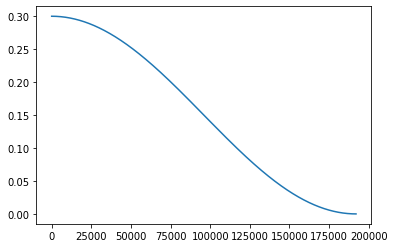

In [90]:
import matplotlib.pyplot as plt
plt.plot(cos)

In [77]:
pruner.step

256001

In [39]:
ckp.pruner["backward_masks"][0].shape

torch.Size([64, 3, 7, 7])

In [40]:
mask1 = ckp.pruner["backward_masks"][0]
mask1.sum()

tensor(3968, device='cuda:0')

In [35]:
print((layer1.weight ==0).sum() / layer1.weight.numel())
print(ckp.pruner["S"][0])

tensor(0.6287)
0.5799622163919889


In [42]:
1 - 3968 / 9408

0.5782312925170068

In [112]:
torch.zeros(size=mask.shape).shape

torch.Size([1000, 2048])

In [113]:
mask.shape

torch.Size([1000, 2048])

In [116]:
torch.isclose(mask.to(device="cpu"), torch.zeros(size=mask.shape, dtype=torch.bool)).sum()

tensor(1899000)

In [118]:
1899000 / mask.numel()

0.92724609375

In [147]:
mask_actual_sparsities=[]
weight_sparsities=[]
total_els=[]
total_zero_weights=[]
total_mask_zeros=[]
for layer_idx, mask in enumerate(pruner.backward_masks):
    num_els = pruner.N[layer_idx]
    if mask is not None:
        num_zeros = (mask==0).sum().item()
        num_zero_weights = (pruner.W[layer_idx]==0).sum().item()
    else:
        num_zeros = 0
        num_zero_weights=0
    mask_actual_sparsities.append((num_zeros)/num_els)
    total_mask_zeros.append(num_zeros)
    weight_sparsities.append(num_zero_weights/num_els)
    total_els.append(num_els)
    total_zero_weights.append(num_zero_weights)
    
print(f"Total sparsity = {sum(total_zero_weights)/sum(total_els)}")
print(f"Mask total sparisty = {sum(total_mask_zeros)/sum(total_els)}")


Total sparsity = 0.9123512248326779
Mask total sparisty = 0.8991647698898071


In [152]:
for name, _ in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [166]:
conv2 = layer1.get_submodule("0").get_submodule("conv2")
conv3 = layer1.get_submodule("0").get_submodule("conv3")

In [168]:
(conv2.weight==0).sum() / conv2.weight.numel()

tensor(0.8436, device='cuda:0')

In [170]:
(conv3.weight==0).sum() / conv3.weight.numel()

tensor(0.0809, device='cuda:0')

In [171]:
pruner.backward_masks[3].shape

torch.Size([256, 64, 1, 1])

In [181]:
pruner.backward_masks[3].sum() / pruner.backward_masks[3].numel()

tensor(0.9688, device='cuda:0')

In [192]:
((conv3.weight != 0) == pruner.backward_masks[3]).sum()

tensor(15570, device='cuda:0')

In [200]:
non_matched_weights = torch.where(
    ((conv3.weight != 0) == pruner.backward_masks[3]),
    -1,
    conv3.weight
)

(non_matched_weights!=-1).sum()

tensor(814, device='cuda:0')

In [212]:
for idx in range(0,non_matched_weights.shape[0]):
    if (non_matched_weights[idx]!=-1).any():
        continue
    else:
        print(idx)

4
70
150
167
173
191


In [178]:
conv3.weight.shape

torch.Size([256, 64, 1, 1])

In [213]:
count_till = 4
for idx, (pruner_s, mask_s, w_s) in enumerate(list(zip(pruner.S, mask_actual_sparsities, weight_sparsities))):
    print(idx)
    print(f"pruner s: {pruner_s}")
    print(f"mask_s: {mask_s}")
    print(f"weight_s: {w_s}")
    # if idx >= count_till:
    #     break

0
pruner s: 0.5799622163919889
mask_s: 0.5782312925170068
weight_s: 0.6287202380952381
1
pruner s: 0.0
mask_s: 0.0
weight_s: 0.0
2
pruner s: 0.822661517028665
mask_s: 0.8211805555555556
weight_s: 0.8435872395833334
3
pruner s: 0.04118111259155077
mask_s: 0.03125
weight_s: 0.0809326171875
4
pruner s: 0.04118111259155077
mask_s: 0.03125
weight_s: 0.1087646484375
5
pruner s: 0.04118111259155077
mask_s: 0.0390625
weight_s: 0.08319091796875
6
pruner s: 0.822661517028665
mask_s: 0.8211805555555556
weight_s: 0.8468695746527778
7
pruner s: 0.04118111259155077
mask_s: 0.03125
weight_s: 0.0355224609375
8
pruner s: 0.04118111259155077
mask_s: 0.0390625
weight_s: 0.06842041015625
9
pruner s: 0.822661517028665
mask_s: 0.8211805555555556
weight_s: 0.8283148871527778
10
pruner s: 0.04118111259155077
mask_s: 0.03125
weight_s: 0.0328369140625
11
pruner s: 0.4253042072365506
mask_s: 0.421875
weight_s: 0.47869873046875
12
pruner s: 0.9133158907863996
mask_s: 0.9131944444444444
weight_s: 0.916388617621527

In [174]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [164]:
# for name, p in model.named_parameters():
#     print(name)
#     print(p)
#     break